# Product Demand Forecasting

Importing libraries

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX

Importing dataset

In [54]:
df = pd.read_csv("D:\MIT\SY\Sem-III\Machine Learning\Project\Final Project\Historical Product Demand.csv")

Inspecting dataset and handling missing values

In [55]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [56]:
df.shape

(1048575, 5)

In [57]:
df.isna().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [58]:
df.dropna(axis = 0, how ='any', inplace = True)

In [59]:
df.shape

(1037336, 5)

In [60]:
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2011-01-08,Product_0965,Whse_A,Category_006,2
2011-05-31,Product_1724,Whse_A,Category_003,108
2011-06-24,Product_1521,Whse_S,Category_019,85000
2011-06-24,Product_1521,Whse_S,Category_019,7000
2011-09-02,Product_1507,Whse_C,Category_019,1250


Feature engineering

In [61]:
def convert_order_demand(x):
    try:
        return int(x)
    except:
        return int(x[1:-1])

df.Order_Demand = df.Order_Demand.apply(lambda x: convert_order_demand(x) )

In [62]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Order_Demand         int64
dtype: object

In [63]:
df['Week'] = df.index.isocalendar().week.astype(int)
df['Month'] = df.index.month
df.head()

,Product_Code,Warehouse,Product_Category,Order_Demand,Week,Month
Date,,,,,,
2011-01-08,Product_0965,Whse_A,Category_006,2,1,1
2011-05-31,Product_1724,Whse_A,Category_003,108,22,5
2011-06-24,Product_1521,Whse_S,Category_019,85000,25,6
2011-06-24,Product_1521,Whse_S,Category_019,7000,25,6
2011-09-02,Product_1507,Whse_C,Category_019,1250,35,9


In [64]:
columns_to_drop = ['Product_Code', 'Warehouse', 'Product_Category']
df.drop(columns = columns_to_drop, inplace = True)
df.head()

,Order_Demand,Week,Month
Date,,,
2011-01-08,2,1,1
2011-05-31,108,22,5
2011-06-24,85000,25,6
2011-06-24,7000,25,6
2011-09-02,1250,35,9


Visualizing dataset

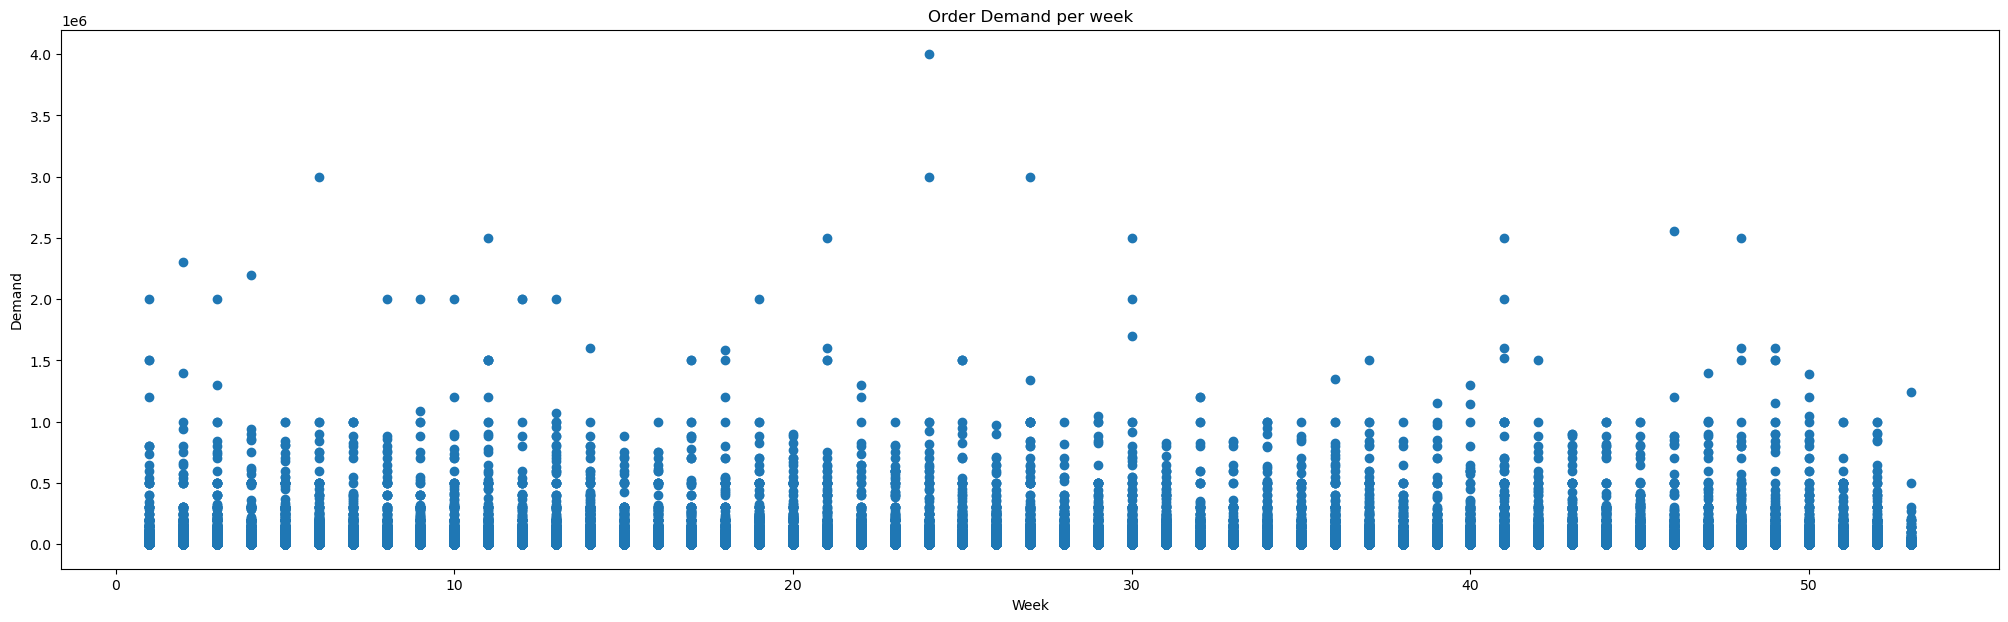

In [65]:
fig, ax = plt.subplots(figsize=(25, 7))
plt.scatter(df['Week'], df['Order_Demand'])
plt.title('Order Demand per week')
plt.xlabel('Week')
plt.ylabel('Demand')
plt.show()

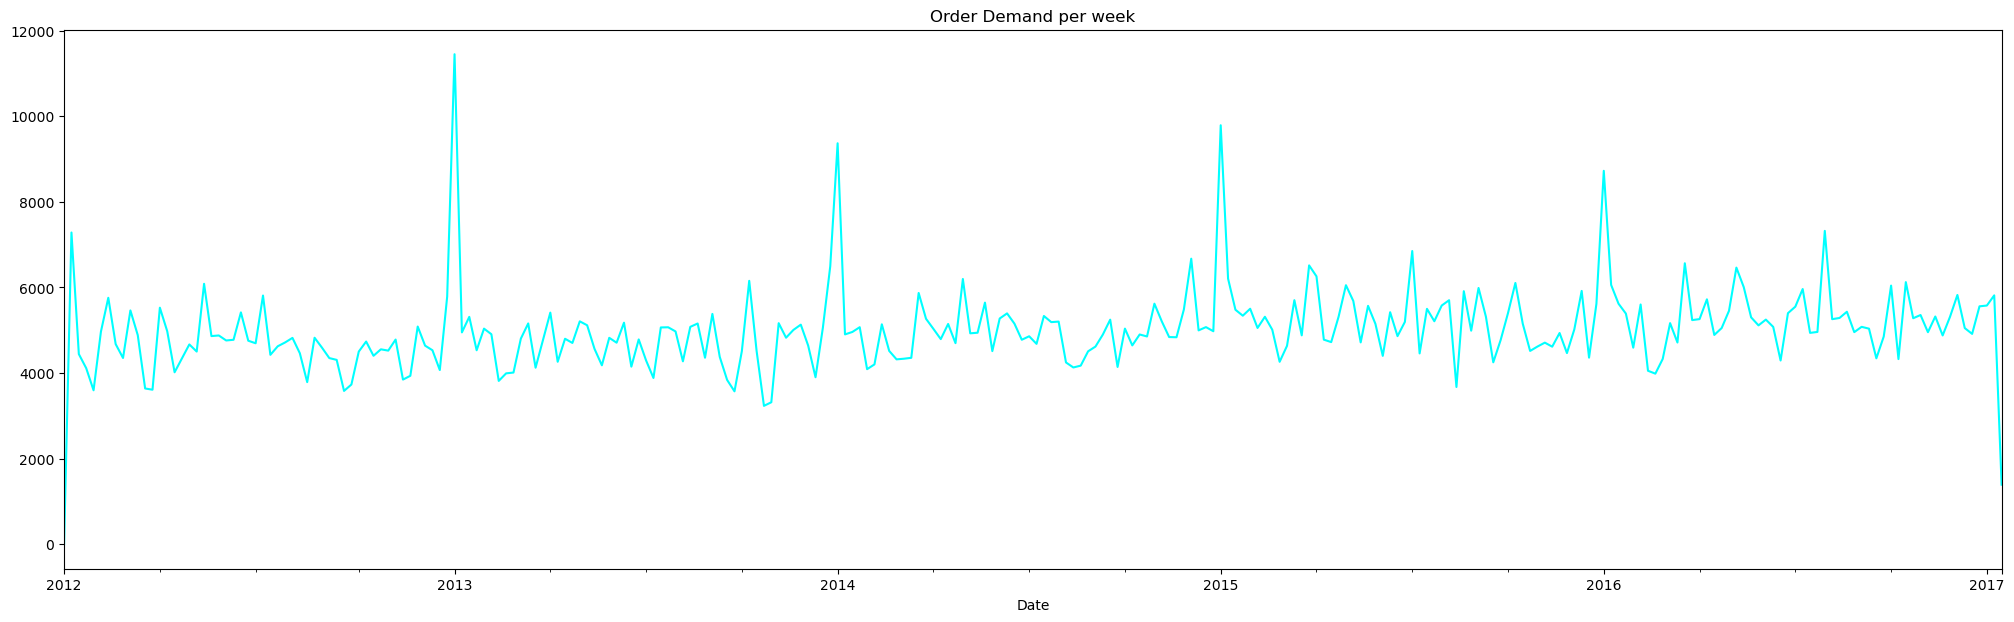

In [66]:
week_df = df[df.index >= '2012-01-01']
week_df = week_df.groupby(pd.Grouper(freq = 'W')).mean()
week_df['Order_Demand'].plot(figsize = (25,7), title = 'Order Demand per week', color = 'cyan')
plt.show()

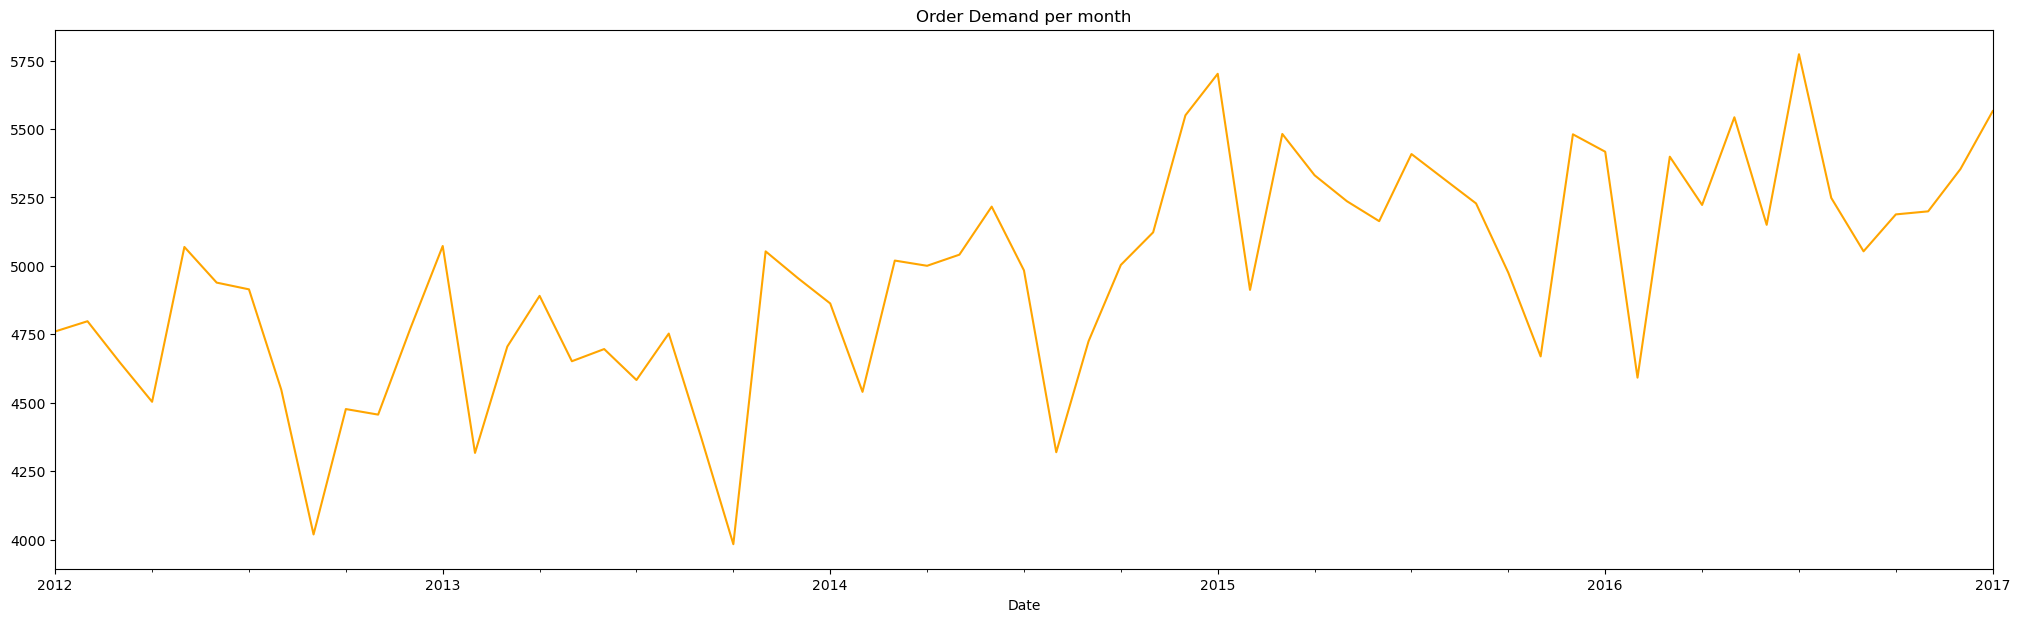

In [67]:
month_df = df[df.index >= '2012-01-01']
month_df = month_df.groupby(pd.Grouper(freq = 'MS')).mean()
month_df['Order_Demand'].plot(figsize = (25,7), title = 'Order Demand per month', color = 'orange')
plt.show()

Decomposing time series data to discover and understand trends

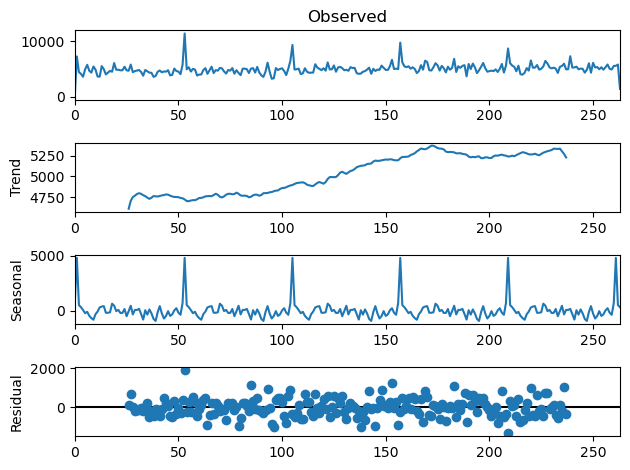

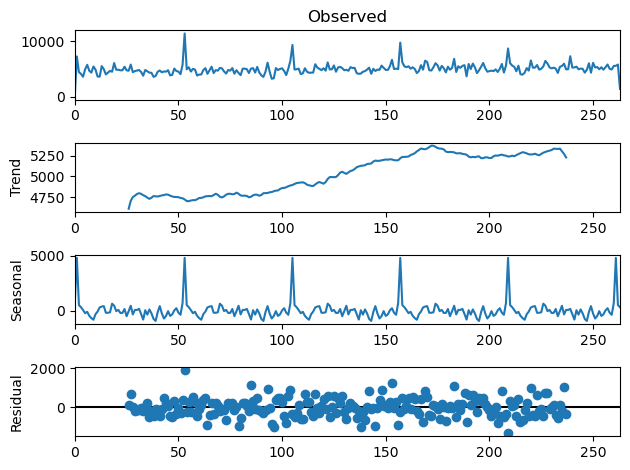

In [68]:
result = seasonal_decompose(week_df.Order_Demand.values, model = 'additive', period = 52)
result.plot()

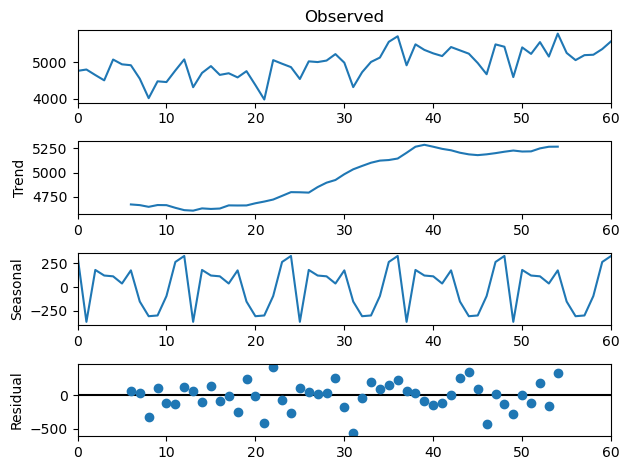

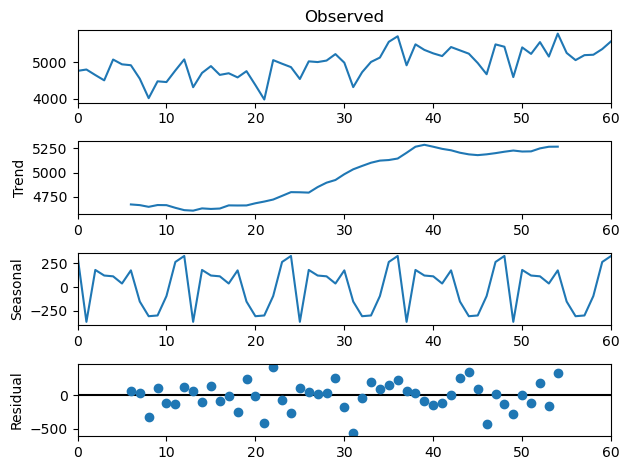

In [69]:
result = seasonal_decompose(month_df.Order_Demand.values, model = 'additive', period = 12)
result.plot()

Performing Augmented Dicker-Fuller test to check stationarity of data

In [70]:
adfuller(month_df['Order_Demand'])

(-2.135356249153704,
 0.23053730809929251,
 2,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 714.3239865088048)

Differencing to remove seasonal trends and make the data stationary

In [71]:
month_diff = month_df['Order_Demand'].diff(1)
month_diff.head()

Date
2012-01-01           NaN
2012-02-01     37.331220
2012-03-01   -150.308697
2012-04-01   -144.000756
2012-05-01    565.562992
                 ...    
2016-09-01   -195.015072
2016-10-01    134.856135
2016-11-01     11.110952
2016-12-01    154.454817
2017-01-01    211.735126
Freq: MS, Name: Order_Demand, Length: 61, dtype: float64

<AxesSubplot:title={'center':'Differenced Time Series (Seasonal Period = 12 months)'}, xlabel='Date'>

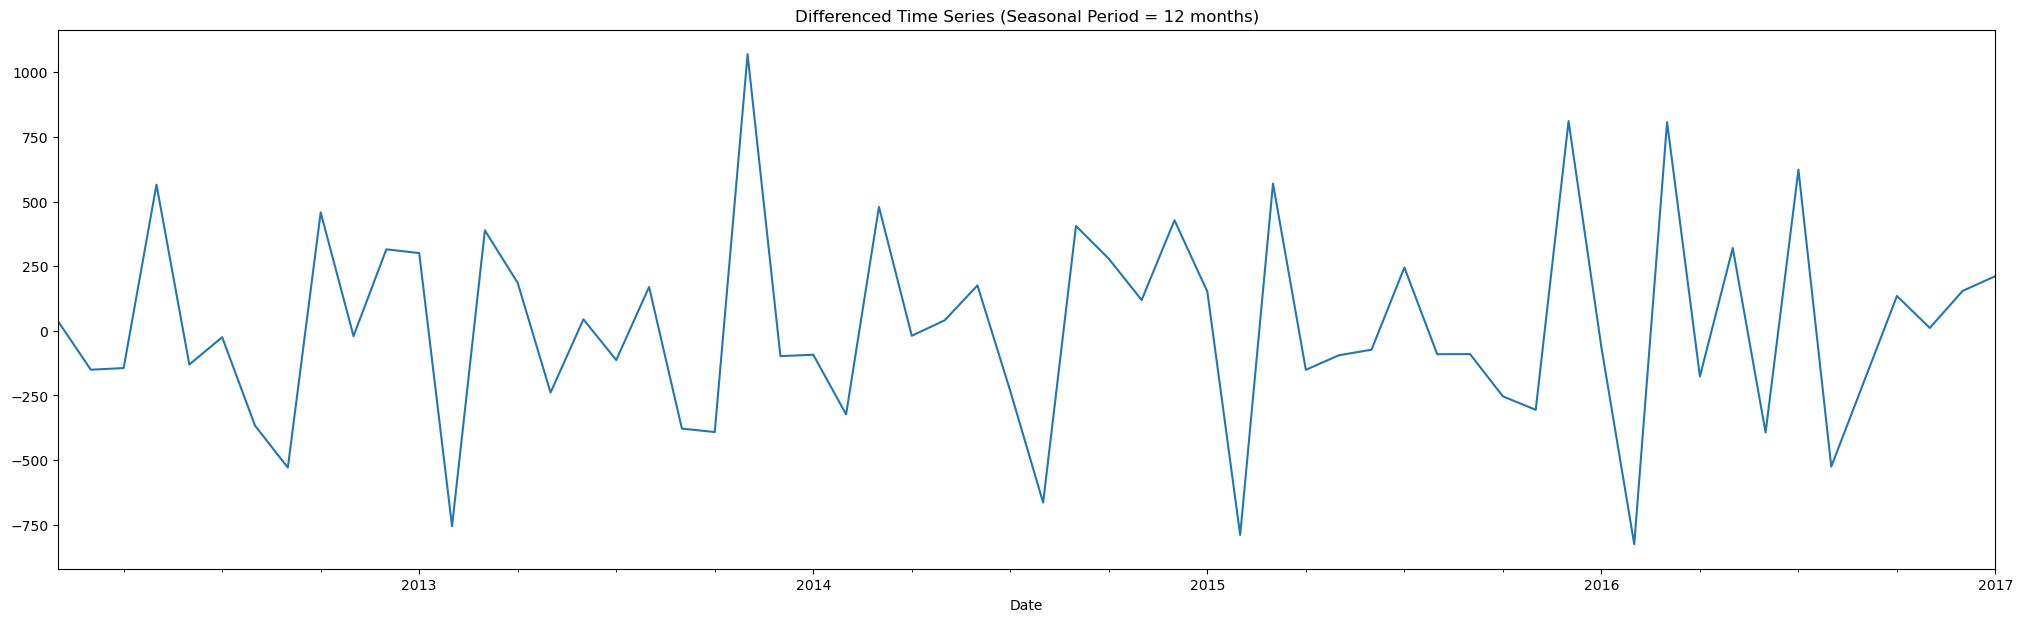

In [72]:
month_diff.dropna().plot(figsize = (25, 7), title = 'Differenced Time Series')

Performing Augmented Dicker-Fuller test again to check the stationarity of data

In [73]:
adfuller(month_diff.dropna())

(-6.758687705873296,
 2.8284296959133446e-09,
 2,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 700.6632081217224)

Plotting ACF and PACF to find the values of p,d and q in ARIMA model

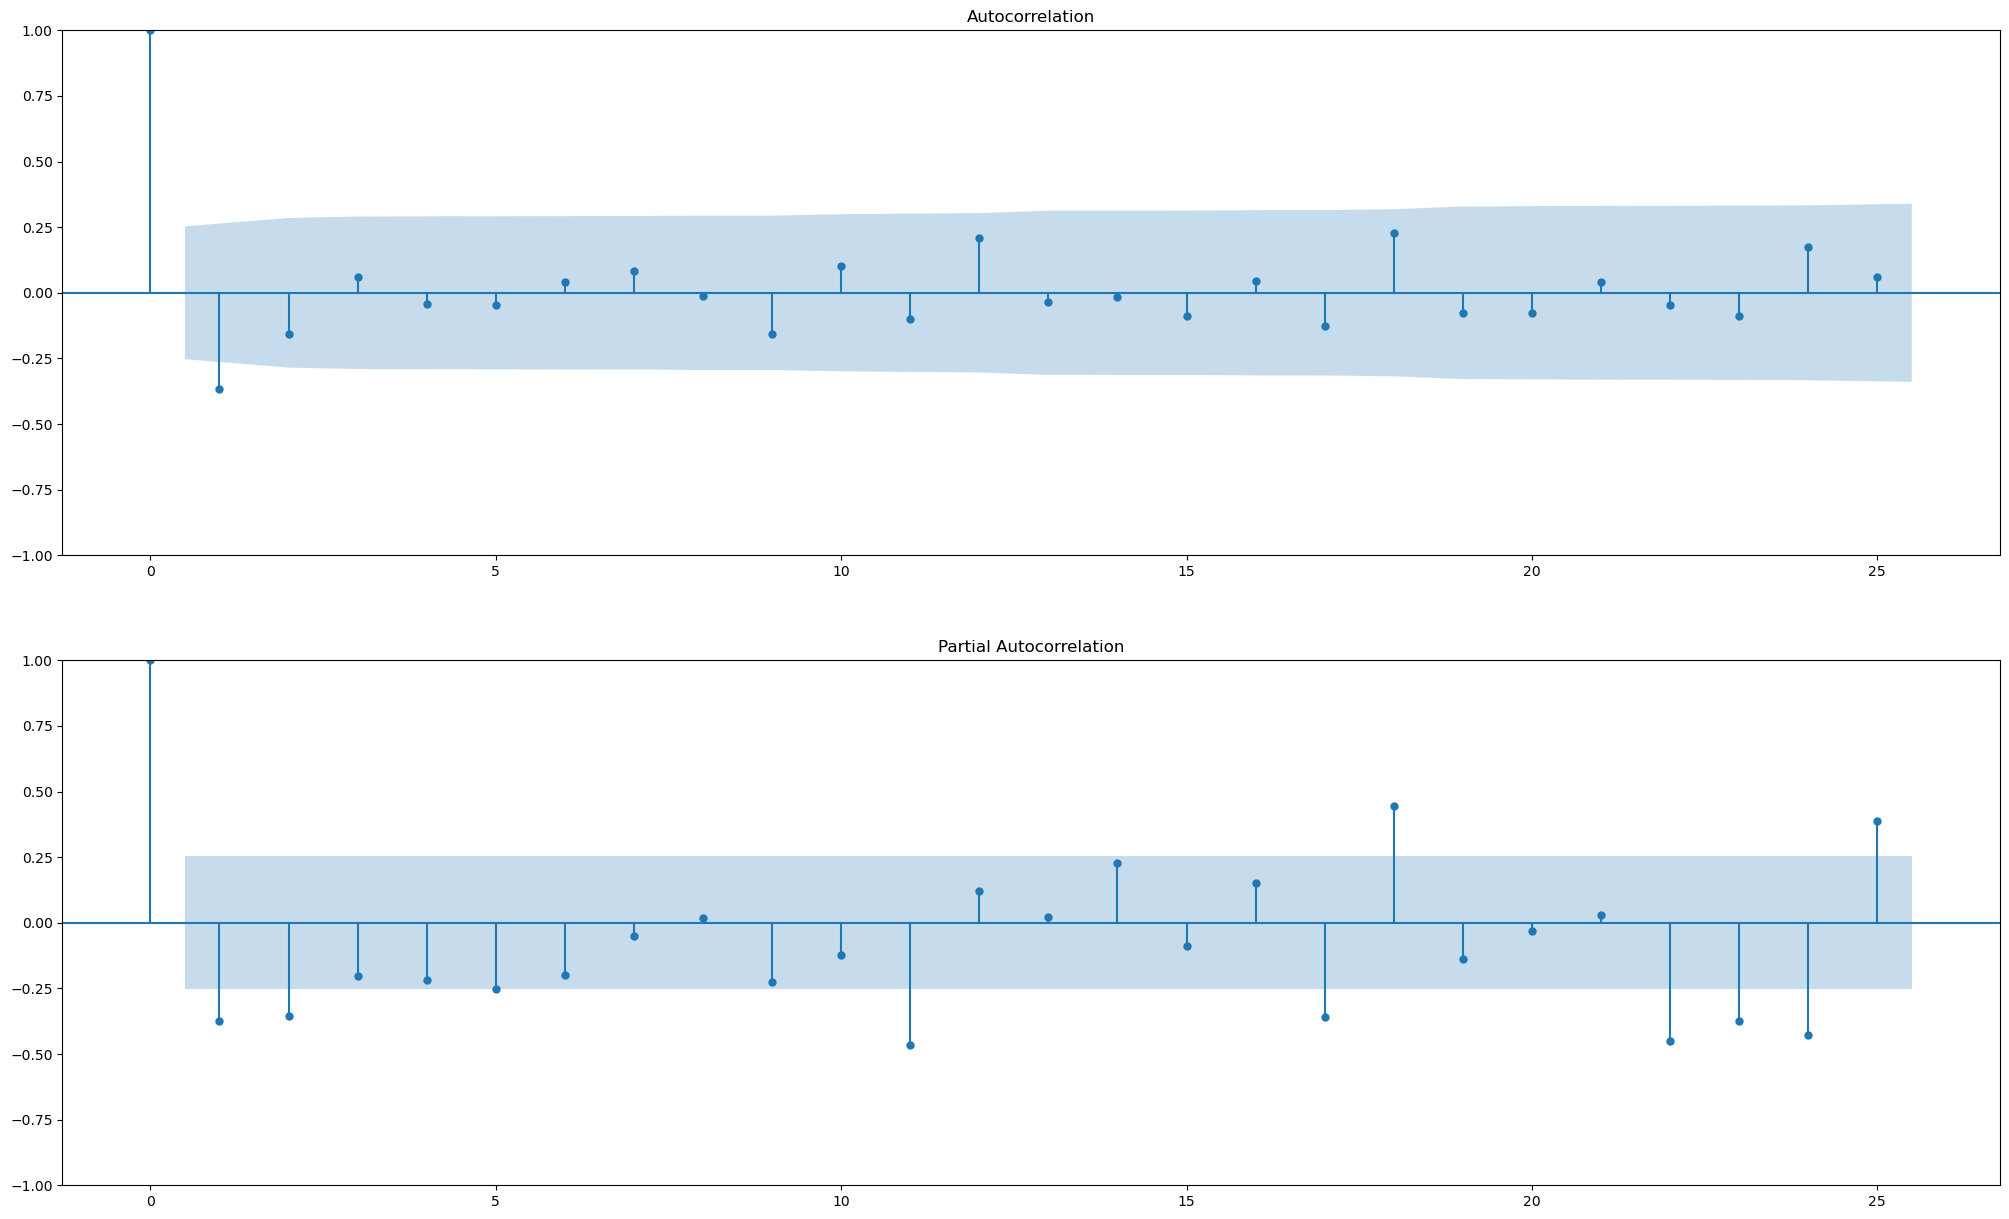

In [76]:
fig = plt.figure(figsize = (25,15))
ax1 = fig.add_subplot(211)
fig = plot_acf(month_diff.dropna(), lags = 25, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(month_diff.dropna(), lags = 25, method = 'ols-adjusted', ax = ax2)
plt.show()

Splitting the dataset into training, testing and visualizing it

In [79]:
train_df, test_df = train_test_split(month_diff, test_size = 0.2, random_state = 42, shuffle = False)
fig, ax = plt.subplots(figsize = (25, 7))
ax.plot(train_df, label = 'Training Set', color = 'red')
ax.plot(test_df, label = 'Testing Set', color = 'green')
ax.set_title('Train Test Split')
ax.legend()
plt.show()

Building ARIMA model

In [100]:
arima = ARIMA(train_df, order = (2, 1, 1))
arima_fit = arima.fit()
print(arima_fit.summary())

Calculating and visualizing the residuals in the model

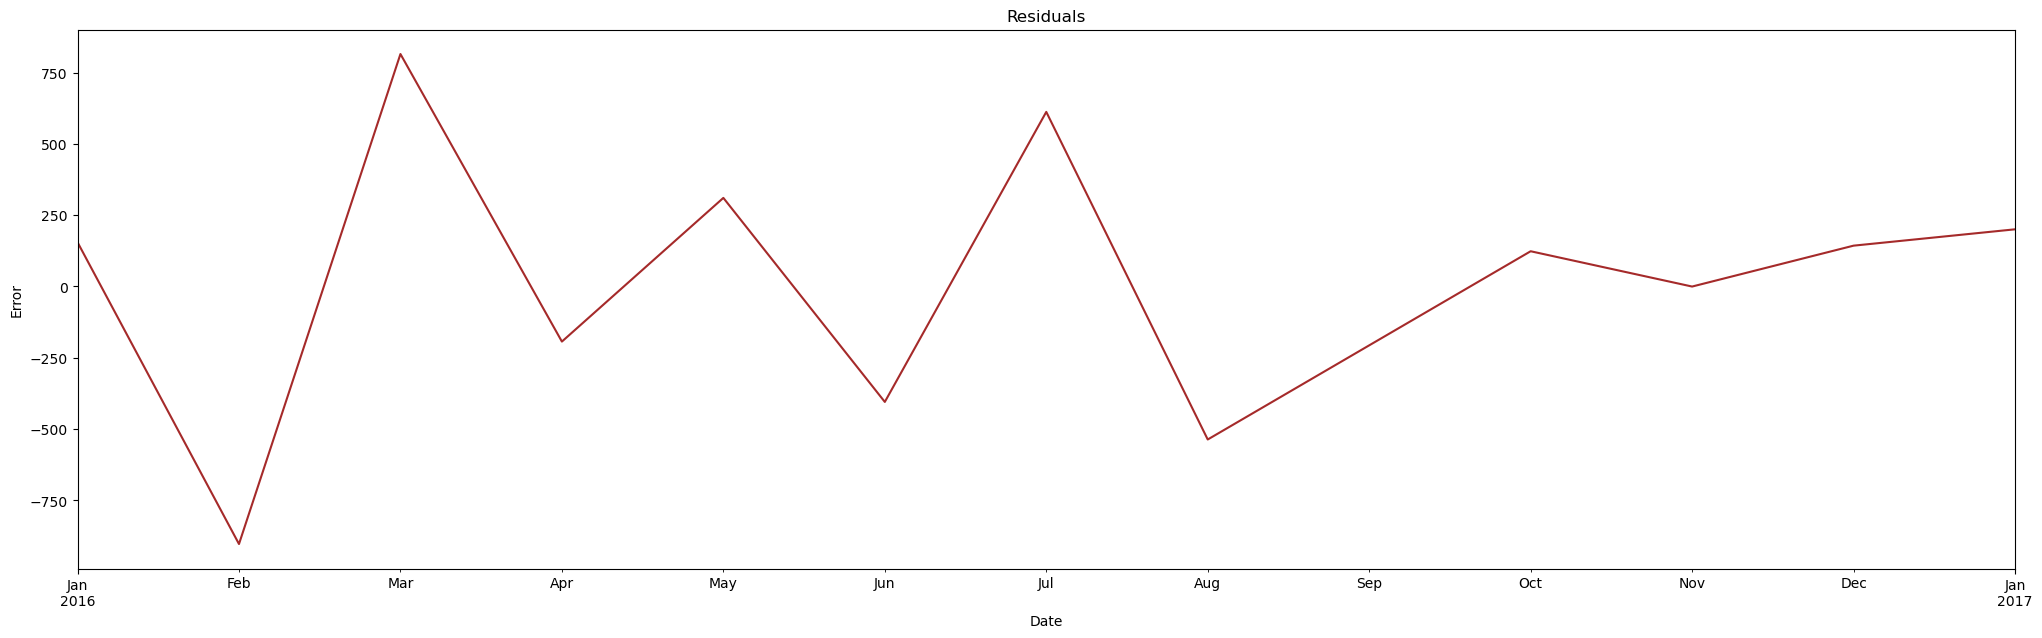

In [107]:
start = test_df.index[0]
end = test_df.index[-1]
pred = arima_fit.predict(start = start, end = end)
residual = test_df - pred
residual.plot(kind = 'line', title = 'Residuals', color = 'brown', figsize = (25,7))
plt.ylabel('Error')
plt.show()

Evaluating the model based on RMSE

In [102]:
rmse = sqrt(mean_squared_error(test_df, pred))
print('RMSE :', rmse)

RMSE: 390.8777035713441


Building SARIMA model

In [113]:
sarima = SARIMAX(train_df, order=(2, 1, 1), seasonal_order = (1, 1, 1, 12))
sarima_fit = sarima.fit()
print(sarima_fit.summary())

C:\Users\Atharva\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Atharva\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Calculating and visualizing the residuals in the model

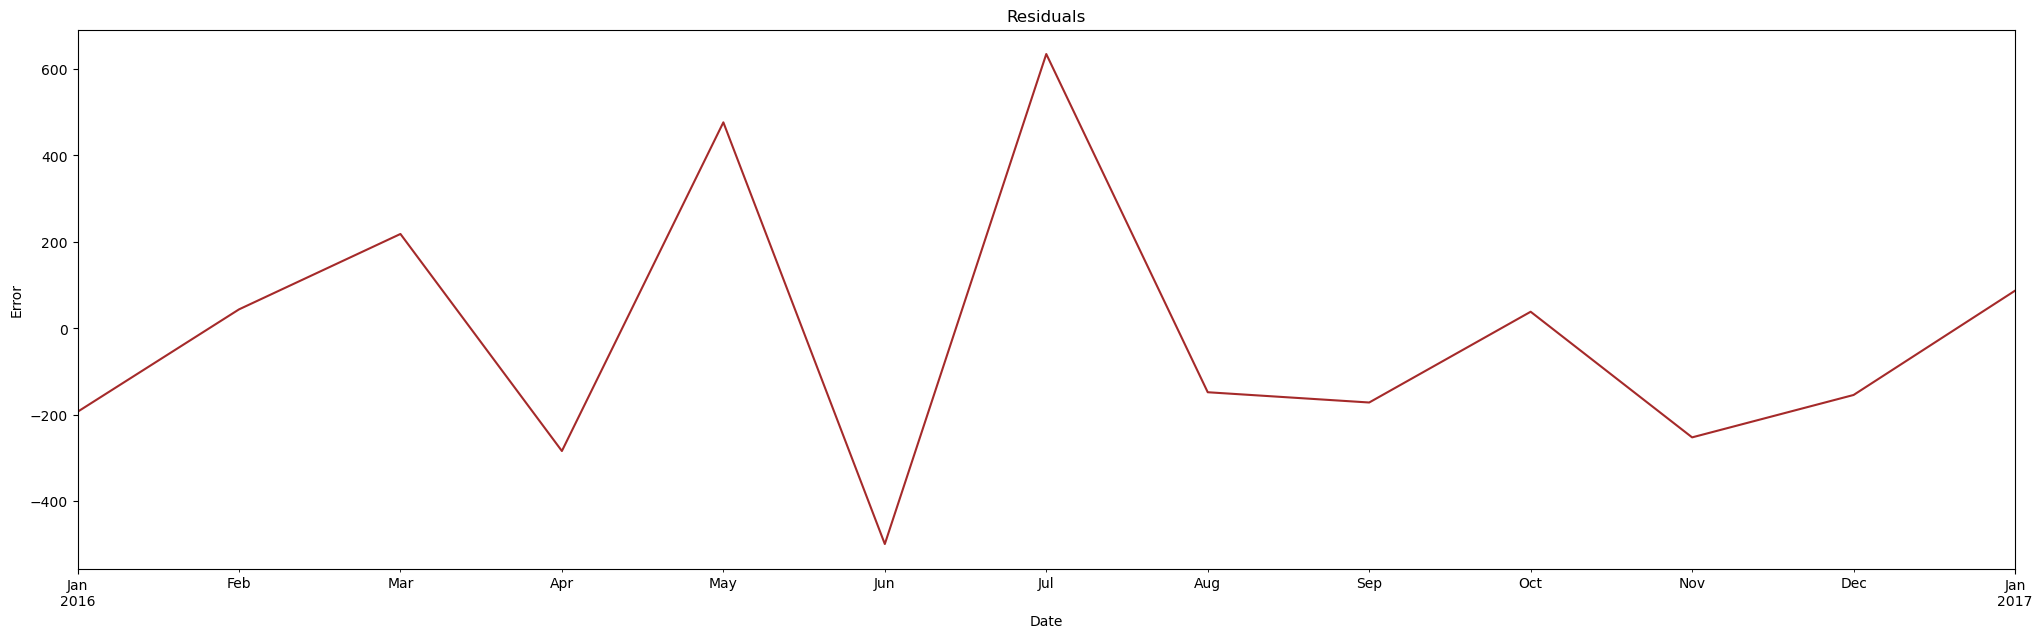

In [116]:
pred = sarima_fit.predict(start = start, end = end)
residual = test_df - pred
residual.plot(kind = 'line', title = 'Residuals', color = 'brown', figsize = (25,7))
plt.ylabel('Error')
plt.show()

Evaluating the model based on RMSE

In [117]:
rmse = sqrt(mean_squared_error(test_df, pred))
print('RMSE :', rmse)

RMSE : 303.08327830168116


Predicting the order demand cumulative for each month

In [120]:
pred.iloc[0] = month_df.loc['2016-01-01', 'Order_Demand']
pred_val = pred.cumsum()
pred_val

2016-01-01    5416.990630
2016-02-01    4548.249893
2016-03-01    5137.405784
2016-04-01    5245.214833
2016-05-01    5089.263894
Freq: MS, Name: predicted_mean, dtype: float64

Visualizing the actual vs. predicted order demand

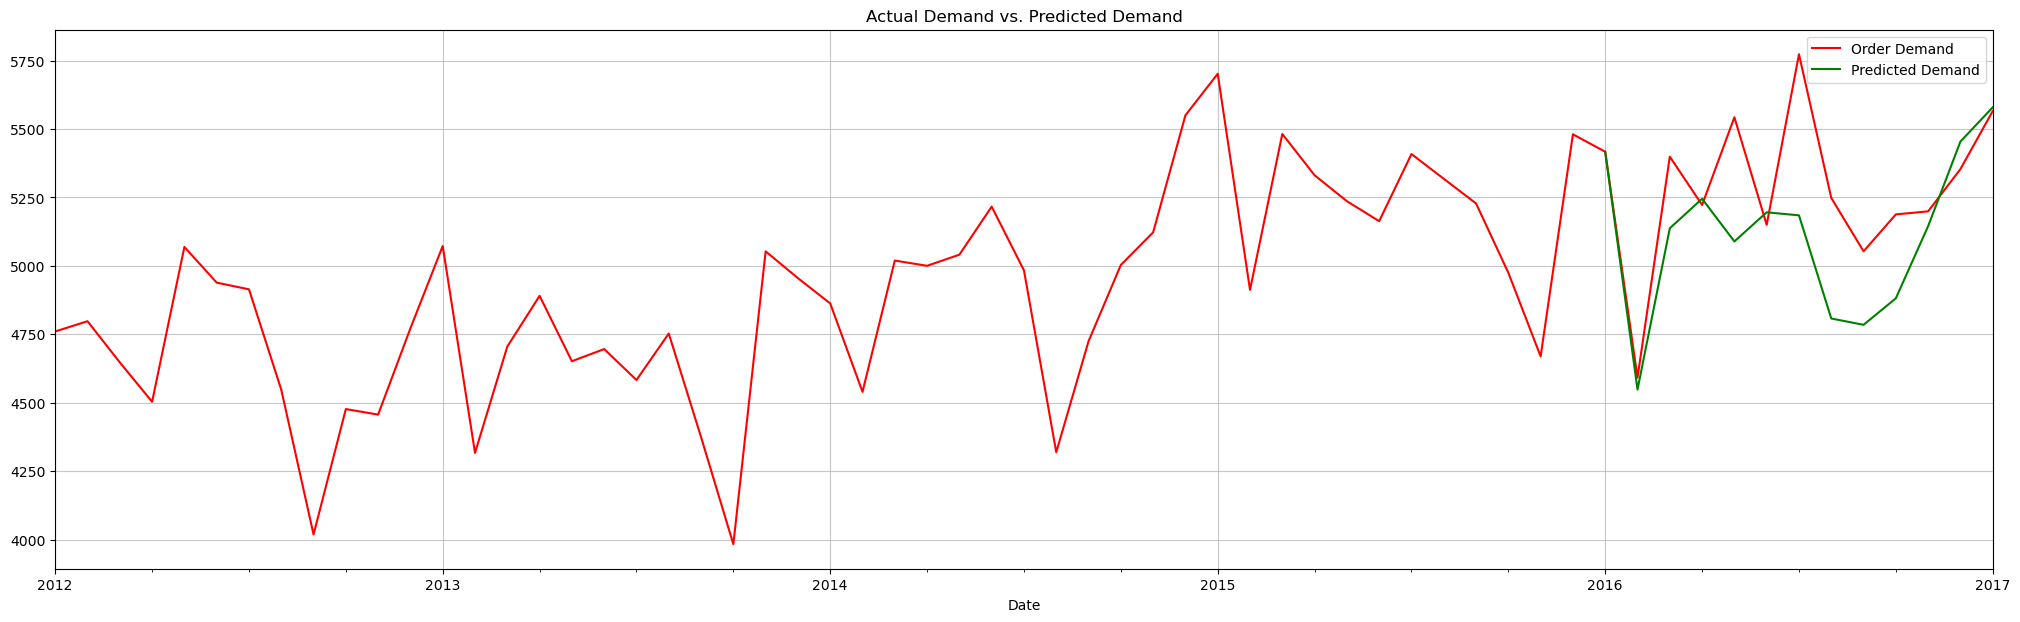

In [127]:
fig, ax = plt.subplots(figsize = (25, 7))
month_df.Order_Demand.plot(ax = ax, title = 'Actual Demand vs. Predicted Demand', color = 'red')
pred_val.plot(ax = ax, color = 'green')
ax.legend(['Order Demand', 'Predicted Demand'])
ax.grid(alpha = 0.7)
plt.show()

Predicting order demand beyond currently available data for next year 

In [128]:
pred_2017 = sarima_fit.predict(start = '2017-01-01', end = '2017-12-01')
pred_2017.iloc[0] = month_df.loc['2017-01-01', 'Order_Demand']
pred_2017 = pred_2017.cumsum()
pred_2017

2017-01-01    5565.415094
2017-02-01    4948.058126
2017-03-01    5406.472928
2017-04-01    5384.417387
2017-05-01    5351.498667
2017-06-01    5370.785306
2017-07-01    5405.229681
2017-08-01    5162.076092
2017-09-01    5116.584267
2017-10-01    5083.805593
2017-11-01    5184.286193
2017-12-01    5657.293847
Freq: MS, Name: predicted_mean, dtype: float64

Visualizing the predicted order demand

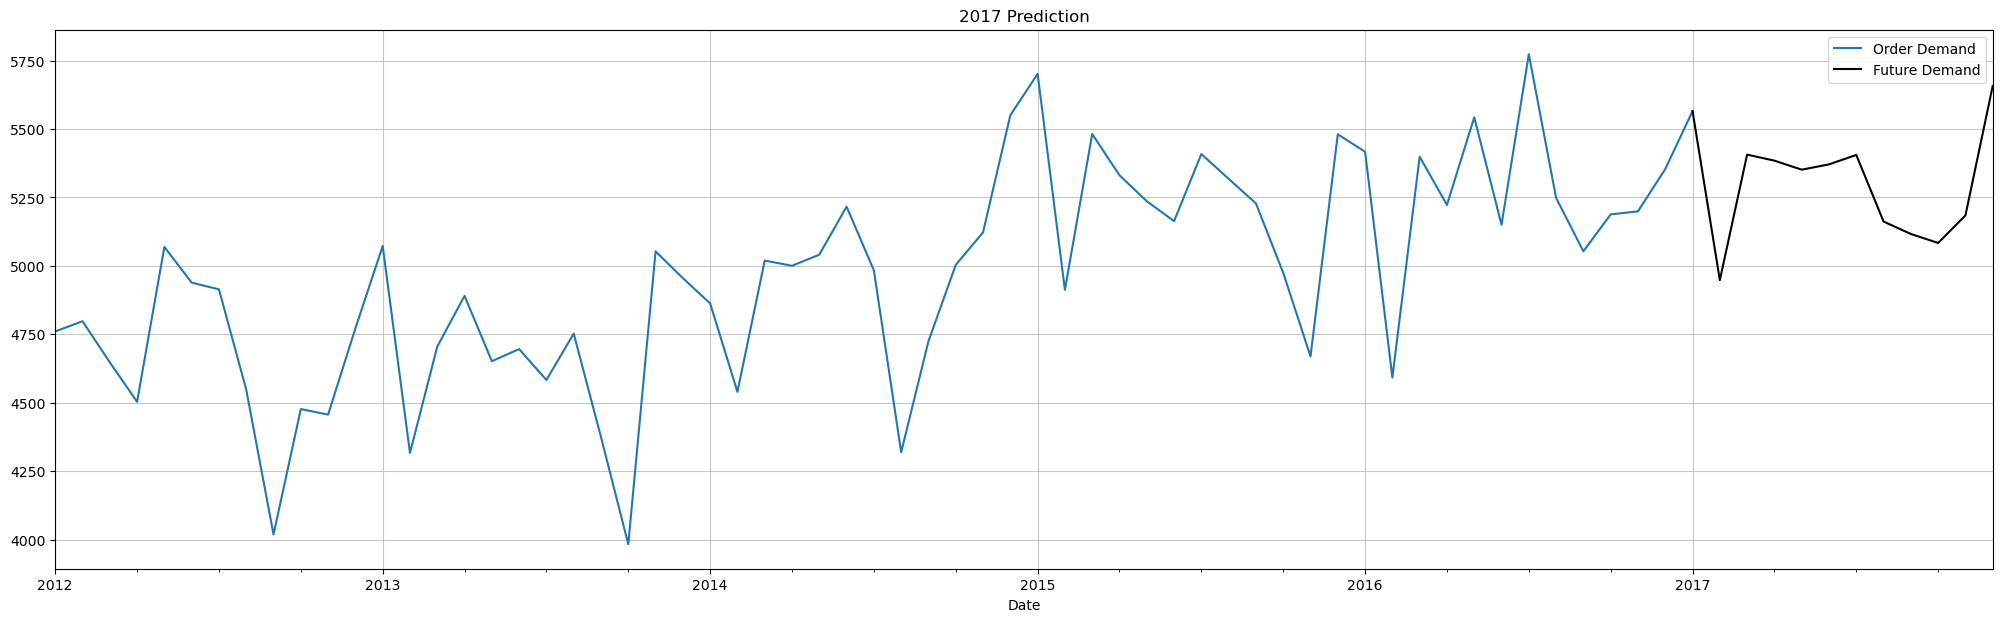

In [131]:
fig, ax = plt.subplots(figsize = (25, 7))
month_df.Order_Demand.plot(ax = ax, title = 'Prediction for the year 2017')
pred_2017.plot(ax = ax, color = 'black')
ax.legend(['Present Demand', 'Future Demand'])
ax.grid(alpha = 0.7)
plt.show()